In [1]:
import os
os.chdir("/home/azureuser/cloudfiles/code/Users/maciej.filanowicz/token_classification/")

In [2]:
from hydra import initialize, compose
from hydra.utils import instantiate
from hydra.core.config_store import ConfigStore
from src.config import NERConfig
from src.data import DocumentWarehouse, NERDataset
from src.model import ModelTrainer
from torch.utils.data import DataLoader
import torch
from transformers import LayoutLMv3Processor

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# cs = ConfigStore.instance()
# cs.store(name='ner_config', node=NERConfig)

In [4]:
initialize(version_base="1.2", config_path="../conf", job_name="test_app")
cfg  = compose(config_name="config2", return_hydra_config=True)

In [5]:
device = torch.device('cuda')

In [6]:
processor = LayoutLMv3Processor.from_pretrained(cfg.model.pretrained_model_name,
                                                                 apply_ocr=False)

In [7]:
dataset = DocumentWarehouse("datasets/FUNSD/images",
                            "datasets/FUNSD/annotations").get_datasets(test_percentage=cfg.params.test_percentage,
                                                                      validation_percentage=cfg.params.validation_percentage)
test_dataset = NERDataset(dataset['test_dataset'],processor, cfg.dataset.label2id)
# test_dataset = NERDataset(dataset['test_dataset'], model_handler.processor, cfg.dataset.label2id)
# validation_dataset = NERDataset(dataset['validation_dataset'], model_handler.processor, cfg.dataset.label2id)

In [13]:
model = torch.load("models/model.pth")
model.eval()

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

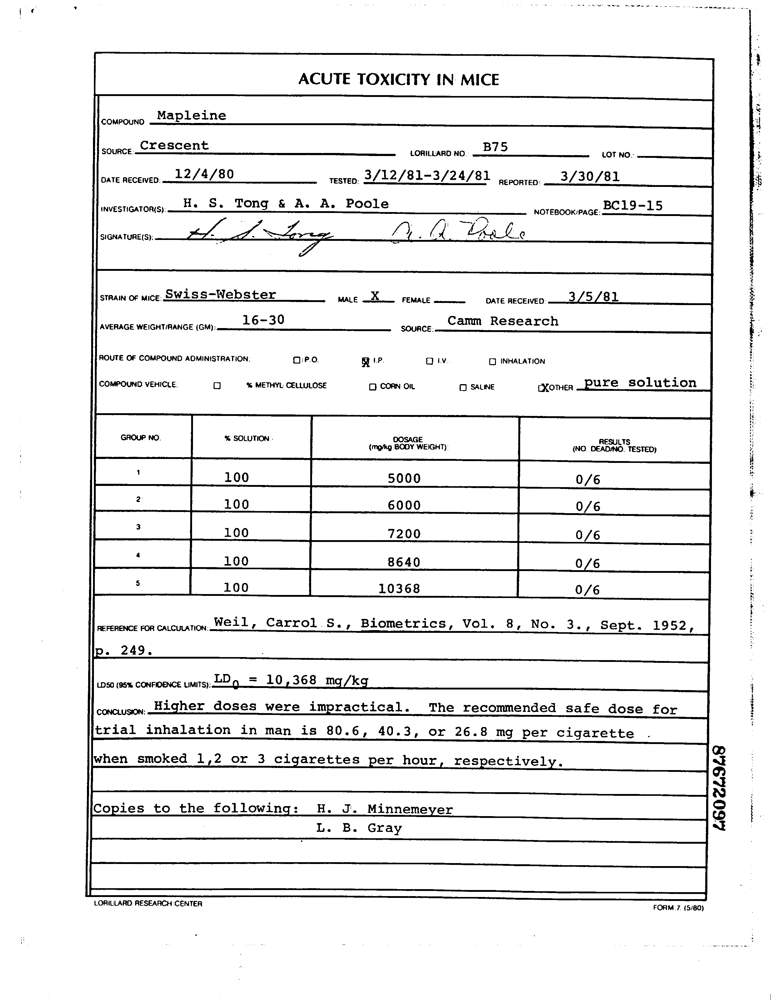

In [62]:
x = Image.open(dataset['test_dataset']['image_path'].iloc[0]).convert("RGB")
x

In [71]:
processed_image = processor.feature_extractor(images=np.array(x))['pixel_values'][0]
Image.fromarray(processed_image[0])

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=224x224 at 0x7F8CBE408E20>

In [ ]:
# encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels,
#                                 return_special_tokens_mask=True,
#                                 return_offsets_mapping=True,
#                                 padding="max_length", truncation=True, return_tensors='pt')

In [75]:
example = test_dataset.__getitem__(0)

In [76]:
for k in example:
    example[k] = torch.unsqueeze(example[k],0).to(device)

In [77]:
from PIL import Image

In [78]:
def infer_model(model, model_inputs):
    outputs = model(input_ids=model_inputs['input_ids'].to(device),
                             attention_mask=model_inputs['attention_mask'].to(device),
                             bbox=model_inputs['bbox'].to(device),
                             labels=model_inputs['labels'].to(device),
                             pixel_values=model_inputs['pixel_values'].to(device))
    return outputs, model_inputs['offset_mapping'], model_inputs['special_tokens_mask']

In [79]:
outputs, offset_mapping, special_tokens_mask = infer_model(model,example)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/transformers/modeling_utils.py:812: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [80]:
cfg.dataset.id2label

{0: 'B-answer', 1: 'E-answer', 2: 'I-answer', 3: 'S-answer', 4: 'B-header', 5: 'E-header', 6: 'I-header', 7: 'S-header', 8: 'other', 9: 'B-question', 10: 'E-question', 11: 'I-question', 12: 'S-question'}

In [81]:
import numpy as np

In [82]:
def aggregate_tokens(scores, offset_mapping, original_boxes, input_ids, special_tokens_mask):
    pre_entities = []
    previous_ind = (0, 0)
    previous_token = ''
    scores_temp = []
    labels_temp = []
    counter = 0
    for idx, token_scores in enumerate(scores):
        if special_tokens_mask[idx]:
            continue
        if offset_mapping is not None:
            start_ind, end_ind = offset_mapping[idx]
            if not isinstance(start_ind, int):
                start_ind = start_ind.item()
                end_ind = end_ind.item()
            word = processor.tokenizer.convert_ids_to_tokens(int(input_ids[idx]))
            label = cfg.dataset.id2label[int(token_scores.argmax())]
            confidence = token_scores[token_scores.argmax()]
            if start_ind == previous_ind[1]:
                previous_ind = start_ind, end_ind
                previous_token += word.strip('#')

                labels_temp.append(label)
                scores_temp.append(confidence)
            else:
                entity = {'text': previous_token, 'scores': np.array(scores_temp), 'labels': labels_temp,
                                        'coordinates': original_boxes[counter]}
                pre_entities.append(entity)
                previous_ind = start_ind, end_ind
                previous_token = word
                labels_temp = [label]
                scores_temp = [confidence]
                counter += 1
    return pre_entities

In [83]:
scores.shape

(1, 512, 13)

In [84]:
logits = outputs["logits"].detach().cpu().numpy()
maxes = np.max(logits, axis=-1, keepdims=True)
shifted_exp = np.exp(logits - maxes)
scores = shifted_exp / shifted_exp.sum(axis=-1, keepdims=True)

In [85]:
aggregated_pre_entities =aggregate_tokens(scores[0], offset_mapping.detach().cpu().numpy()[0], example['bbox'][0].detach().cpu().numpy(), example['input_ids'][0],
                                                            special_tokens_mask.detach().cpu().numpy()[0])

In [86]:
aggregated_pre_entities

[{'text': 'ĠCOMPOUND',
  'scores': array([0.99487215, 0.99597245], dtype=float32),
  'labels': ['S-question', 'S-question'],
  'coordinates': array([0, 0, 0, 0])},
 {'text': 'ĠSOURCE',
  'scores': array([0.99651825, 0.9963691 ], dtype=float32),
  'labels': ['S-question', 'S-question'],
  'coordinates': array([128, 115, 186, 125])},
 {'text': 'ĠMapleine',
  'scores': array([0.99550915, 0.9910624 ], dtype=float32),
  'labels': ['S-answer', 'S-answer'],
  'coordinates': array([128, 115, 186, 125])},
 {'text': 'ĠCrescent',
  'scores': array([0.99434704], dtype=float32),
  'labels': ['S-answer'],
  'coordinates': array([128, 147, 171, 154])},
 {'text': 'ĠTESTED:',
  'scores': array([0.9952987 , 0.99732983, 0.9884271 ], dtype=float32),
  'labels': ['S-question', 'S-question', 'S-question'],
  'coordinates': array([128, 147, 171, 154])},
 {'text': 'ĠREPORTED',
  'scores': array([0.9957243, 0.9960258], dtype=float32),
  'labels': ['S-question', 'S-question'],
  'coordinates': array([198, 108, 